# Run IRASA timeresolved

In the original IRASA manuscript Wen & Liu ([2016](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4706469/)) show that the algorithm can be used in the time-frequency domain.
The authors used this in a subsequent manuscript to investigate changes periodic and aperiodic activity over time and even computed broadband correlations of aperiodic activity over channels across time (see [Wen & Liu, 2016](https://doi.org/10.1523/JNEUROSCI.0187-16.2016)). To make this form of analysis more accessible and track aperiodic and periodic changes over time we implemented the irasa_sprint function, that similarly to the SPRiNT package ([Wilson, da Silva Castanheira & Baillet, 2022](https://doi.org/10.7554/eLife.77348)), enables you to compute periodic and aperiodic spectrograms.

In [1]:
import sys
from neurodsp.sim import set_random_seed
from neurodsp.sim import sim_powerlaw, sim_oscillation
from neurodsp.utils import create_times
from neurodsp.plts import plot_timefrequency#

from neurodsp.timefrequency import compute_wavelet_transform
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

set_random_seed(84)

from pyrasa.irasa import irasa_sprint

Lets firs generate a signal with some alpha and beta bursts alongside a change in the spectral exponent

In [2]:
# Set some general settings, to be used across all simulations
fs = 500
n_seconds = 15
duration=4
overlap=0.5

# Create a times vector for the simulations
times = create_times(n_seconds, fs)


alpha = sim_oscillation(n_seconds=.5, fs=fs, freq=10)
no_alpha = np.zeros(len(alpha))
beta = sim_oscillation(n_seconds=.5, fs=fs, freq=25)
no_beta = np.zeros(len(beta))

exp_1 = sim_powerlaw(n_seconds=2.5, fs=fs, exponent=-1)
exp_2 = sim_powerlaw(n_seconds=2.5, fs=fs, exponent=-2)


alphas = np.concatenate([no_alpha, alpha, no_alpha, alpha, no_alpha])
betas = np.concatenate([beta, no_beta, beta, no_beta, beta])

sim_ts = np.concatenate([exp_1 + alphas, 
                         exp_1 + alphas + betas, 
                         exp_1 + betas, 
                         exp_2 + alphas, 
                         exp_2 + alphas + betas, 
                         exp_2 + betas, ])

Now we compute a time frequency spectrum using morlet wavelets and additionally decompose the data in the time frequency domain using pyrasa's `irasa_sprint` function

In [6]:
freqs = np.arange(1, 50, 0.5)
import scipy.signal as dsp

mwt = compute_wavelet_transform(sim_ts, fs=fs, 
                                freqs=freqs, n_cycles=11,
                                )

irasa_sprint_spectrum = irasa_sprint(sim_ts, fs=fs,
                                        band=(1, 50),
                                        overlap_fraction=.95,
                                        win_duration=.5,
                                        hset_info=(1.05, 4., 0.05),
                                        win_func=dsp.windows.hann)

When we now plot the data we can see that we have nicely seperated our prediodic and aperiodic spectra in time

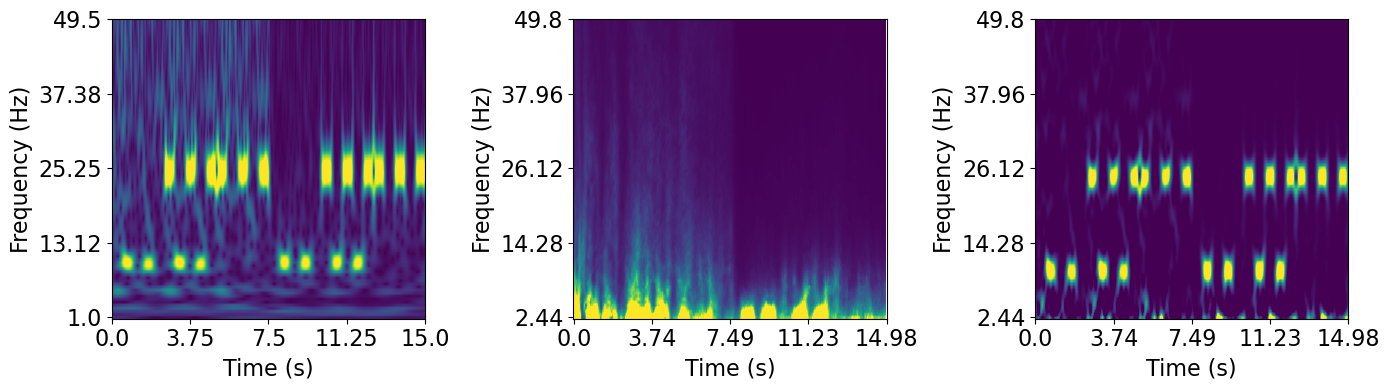

In [8]:
#%%
f, axes = plt.subplots(figsize=(14, 4), ncols=3)
mwt = np.abs(mwt)
plot_timefrequency(times, freqs, mwt, ax=axes[0], vmin=0, vmax=0.5)
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.aperiodic), vmin=0, vmax=0.02, ax=axes[1])
plot_timefrequency(irasa_sprint_spectrum.time, irasa_sprint_spectrum.freqs, np.squeeze(irasa_sprint_spectrum.periodic), vmin=0, vmax=0.1, ax=axes[2])

Now we can specify an aperiodic model and fit it to our aperiodic spectrogram

In [9]:
ap_spec = irasa_sprint_spectrum.fit_aperiodic_model()

We can visualize the aperiodic changes alongside the goodness of fit, to see whether its  matching our expectations

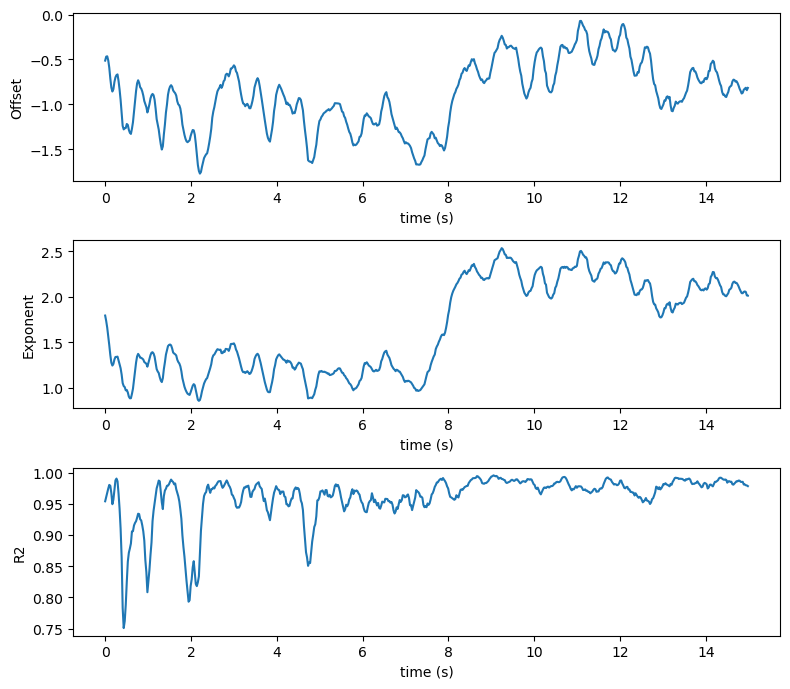

In [10]:
f, ax = plt.subplots(nrows=3, figsize=(8, 7))

ax[0].plot(ap_spec.aperiodic_params['time'], ap_spec.aperiodic_params['Offset'])
ax[0].set_ylabel('Offset')
ax[0].set_xlabel('time (s)')
ax[1].plot(ap_spec.aperiodic_params['time'], ap_spec.aperiodic_params['Exponent'])
ax[1].set_ylabel('Exponent')
ax[1].set_xlabel('time (s)')
ax[2].plot(ap_spec.aperiodic_params['time'], ap_spec.gof['R2'])
ax[2].set_ylabel('R2')
ax[2].set_xlabel('time (s)')

f.tight_layout()

Similarly we can extract our peaks or putatively oscillatory activity in time, by using the `get_peaks` method

In [11]:
peaks_spec = irasa_sprint_spectrum.get_peaks(cut_spectrum=(1, 40),
                                  smooth=True,
                                  smoothing_window=1,
                                  peak_threshold=2,
                                  min_peak_height=0.01,
                                  peak_width_limits=(0.5, 12))

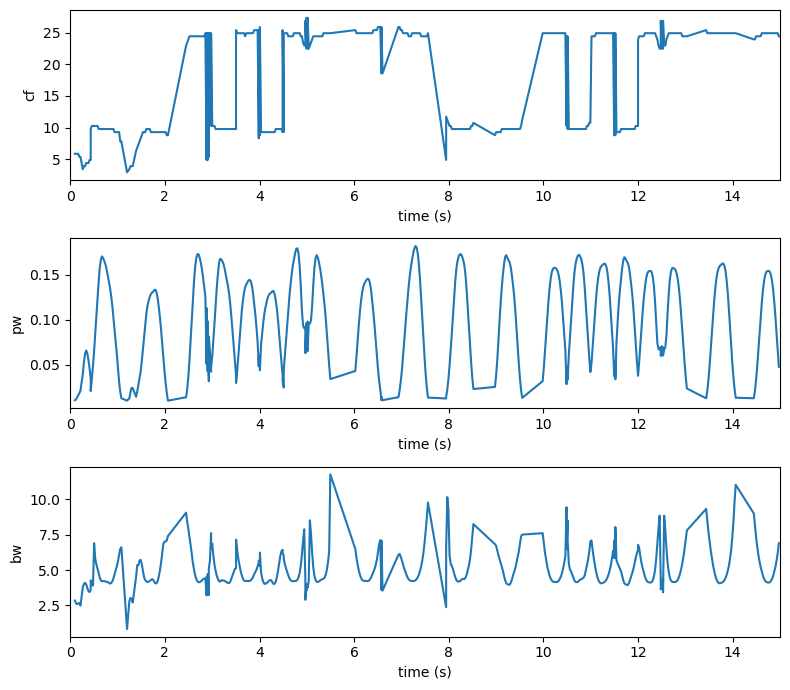

In [12]:
f, ax = plt.subplots(nrows=3, figsize=(8, 7))

for ix, cur_key in enumerate(['cf', 'pw', 'bw']):

    ax[ix].plot(peaks_spec['time'], peaks_spec[cur_key])
    ax[ix].set_ylabel(cur_key)
    ax[ix].set_xlabel('time (s)')
    ax[ix].set_xlim(0, 15)

f.tight_layout()

We can further check whether the number of extracted peaks matches our expectations. Looks pretty good to me :)

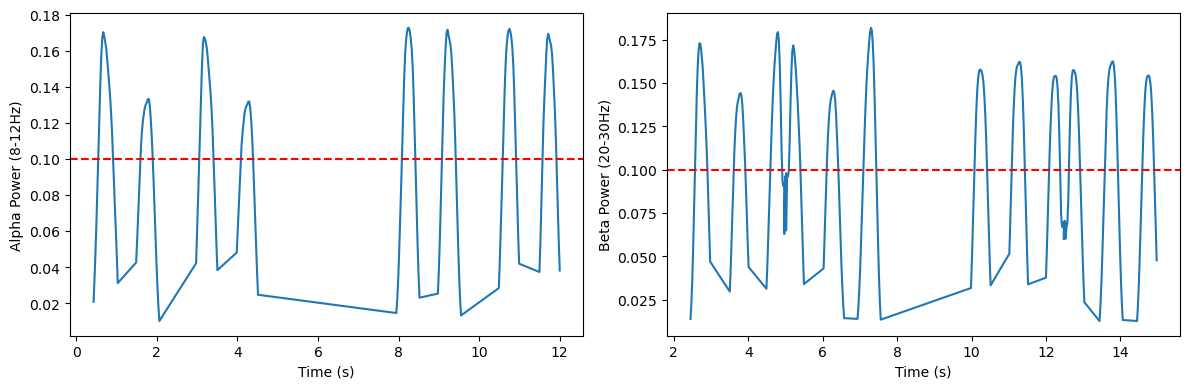

In [14]:
from pyrasa.utils.peak_utils import get_band_info

df_alpha = get_band_info(peaks_spec, freq_range=(8,12), ch_names=[])
alpha_peaks = df_alpha.query('pw > 0.10')

beta_ts = alpha_peaks['time'].to_numpy()
t1 = beta_ts[0]
n_peaks = 0
for ix, i in enumerate(beta_ts):
    try: 
        diff = beta_ts[ix + 1] - i
        if diff > 0.025:
            n_peaks += 1
    except IndexError:
        pass
n_peaks

#%%
df_beta = get_band_info(peaks_spec, freq_range=(20, 30), ch_names=[])
beta_peaks = df_beta.query('pw > 0.10')

beta_ts = beta_peaks['time'].to_numpy()
t1 = beta_ts[0]
n_peaks = 0
for ix, i in enumerate(beta_ts):
    try: 
        diff = beta_ts[ix + 1] - i
        if diff > 0.025:
            n_peaks += 1
    except IndexError:
        pass
n_peaks


# %%
f, ax = plt.subplots(figsize=(12, 4), ncols=2)

ax[0].plot(df_alpha['time'], df_alpha['pw'])
ax[1].plot(df_beta['time'], df_beta['pw'])

yax = ['Alpha Power (8-12Hz)', 'Beta Power (20-30Hz)']
for ix, c_ax in enumerate(ax):
    c_ax.axhline(0.1, color='r', linestyle='--')
    c_ax.set_xlabel('Time (s)')
    c_ax.set_ylabel(yax[ix])

f.tight_layout()